# Optimal Generator

For an interactive version of this notebook, click on the binder link below:
[![Binder](https://mybinder.org/badge_logo.svg)](https://mybinder.org/v2/gh/pjohno/MSc-Math-Finance-Projects/master?filepath=notebooks%2FEnergy%20Markets%20-%20An%20Optimal%20Generator)

Here is a generic solver to find an optimal strategy for a generator subject to different electricity prices.

- $U$ is the current state of the generator
- $x$ is a dummy state space variable for the generator when it is in state $U$
- $p(t)$ is the deterministic price
- $c$ is the control action

The dynamic equations that the generator follows are given by
$$\frac{dx}{dt}=f(x,U,c),$$ 
$$U(t^+)=\eta(x(t),U(t),c).$$

At each given moment of time, if the generator is in the state $U$ and $x$, and the current price of electricity is $p(t)$, then 
$$\Gamma(x,U,p(t))$$
is the rate at which the generator recieves cash (or utility).

The objective of the generator is to maximise the total cash (or utility) of running the generator over some fixed time period $t\in[0,T]$, which can be written as
$$
\max_c \int_0^T \Gamma(x(t),U(t),p(t)) dt .
$$

Now write the value function as 
$$
J(x,U,t) = \max_c \int_t^T \Gamma(x(s),U(s),p(s)) ds 
$$
by standard Bellman derivation we know that the value function satisfies the equation
$$
\frac{\partial J}{\partial t} +  \max_c \left[ f(x,U,c) \frac{\partial J}{\partial x} + \Gamma(x,U,p(t)) \right] = 0 ,   
$$
subject to the jump conditions
$$
J(x,U,t^+) \geq \max_c\left[ J(x,U,t^-) , J(x,\eta(x(t),U(t),c),t^-) \right]
$$


In [1]:
#include "msc_project_energyMarkets.hpp"

The following is an example of a generator with two different states. Each generator will have different states, stored in a class

`GeneratorState`

that has the following members:-

|Member |Description |
|--- |---|
| `std::vector<double> x` | fixed grid for the state variable, with $n+1$ points, must be setup |
| `std::vector<double> v` | value function on grid points, with $n+1$ points, must be setup  |
| `std::vector<std::vector<double>> control` |store the optimal control at each time and grid point, with $n+1$x$m+1$ points, given there are $m+1$ timesteps, must be setup  |
| `double f(double xt,double c) const` | dynamics of the state |
| `std::function<double(double)> cMin` |  cMin controls the minimum rate of f given x , must be setup|
| `std::function<double(double)> cMax` | cMax controls the maximum rate of f given x , must be setup|
| `std::function<int(double)> eta` | eta is way that we jump between states, must be setup |
| `std::function<double(double,double,double)> Gamma` | cost function , must be setup |

The code to solve for a generator and output results is stored in a class

`Generator`

that has the following members:-

|Member |Description |
|--- |---|
| `std::function<double(double)> EP` | a function to assign the electricity price as a function of time |
| `double tol` | the tolerance for the problem |
| `std::vector<GeneratorState> state` | store the different generator states in the problem inside a vector |
| `std::vector<double>  t` | store the time grid in a vector |
| `int solve()` | solve from T to 0 using dynamic programming |
| `int outputPath(double x0,int u0,std::ostream& output=std::cout)` | output the path of the variable |

Create an instance of the `Generator` class called "gen".

In [2]:
MSC_PROJECTS::Generator gen;

Now consider a generator that has two states, "off" and "on", which will be referenced by $U=0$ and $U=1$ respectively. Set the number of states by resizing the vector "state"

In [3]:
gen.state.resize(2);

Now lets setup variables for the grid, so that $t$ is given in hours and $$\Delta t=\frac{1}{stepsPerHour}$$

In [4]:
// store number of steps per hour
int stepsPerHour=100;
// get dt
double dt=1./stepsPerHour;
// store number of hours
double T=24;
// total timestep m= stepsperhour*T
int m=stepsPerHour*T;
gen.t.resize(m+1);
for(int k=0;k<=m;k++)
{
    gen.t[k] = k*dt;
}


For the off state $U=0$, we can setup a simple grid with a small number of points (code works best with $n\geq2$). Let $x_j$ be equidistant grid points on the interval $x \in[-1,0]$.

In [5]:
int n=5;
// state 0 has n points in interval [-1,0]
gen[0].x.resize(n+1,0.);
for(int j=0;j<=n;j++)gen[0].x[j] = -1. + (double)j/(double)n;// GRID

Then setup the value function `v` and `control` with the appropriate number of points

In [6]:
// initialise value function and control
gen[0].v.resize(n+1,0.);
gen[0].control.resize(n+1,std::vector<double>(m+1,0.));

Now since in the "off" state, we assume that the generator has no output and no cost, we clearly have 
$$
\Gamma(U=0,x,p,c)=0 .
$$
For the control, we must allow it to move in and out of the off state, so set $c_\text{min}$ and $c_\text{max}$ as any negative and positive number, so that controls are taken for instance from the interval
$$
c\in[-1,1].
$$
Finally, to trigger the switch to an "on" state, we look at the value of $x$ and $c$ and say that if $x\geq0$, we are turning the generator on. If the optimal control it to keep the generator in the off state, $c$ would be chosen such that $x<0$. So for the function $\eta$ we have
$$
\eta(U=0,x,c)=\left\{ \begin{array}{cc} 1 & \text{ if } x\geq 0 \\ 0 & \text{ if } x<0 \end{array} \right.
$$

In [7]:
// cost function
gen[0].Gamma = [](double,double,double){return 0.;};
// define dynamics, any negative number here
gen[0].cMin = [](double){return -1;};
// define dynamics, any positive number here
gen[0].cMax = [](double){return 1;};
gen[0].eta = [](double xtplus,double ct){
    // if xt would be positive, generator turned on
    if(xtplus>0.)return 1;
    // otherwise stays off
    else return 0;
};

Next move onto the "on" state of the generator, or $U=1$. Here we need to set the number of grid points appropriately. For a numerical scheme like this, a generator that is controlled with a run up rate such that
$$
\frac{dx}{dt} \leq c_\text{max}
$$
and a run down rate
$$
\frac{dx}{dt} \geq c_\text{min}
$$
must try and align grid points as much as possible so that 
$$
x_{j+1} \approx x_j + c_\text{max} \Delta t
$$
and
$$
x_{j-1} \approx x_j + c_\text{min} \Delta t .
$$

If $ c_\text{max}$ and $c_\text{min}$ are related to the quoted RURE and RDRE for a generator, the grid spacing should be something like
$$
\Delta x \approx \min(RURE,RDRE) \Delta t .
$$
Given $x_\text{max}$ as the quoted MEL, then to get the number of points will be given by
$$
n =  \frac{MEL}{\Delta x}.
$$

For a simple example, consider a generator with a Maximum Export limit (MEL) of 10MW
$$
MEL = 10,
$$
a run up rate (RURE) of 2MW per hour
$$
RURE = 25,
$$
and run down rate (RDRE) of 2MW per hour
$$
RDRE = 20,
$$
we can set grid points as
$$
n=\frac{MEL \cdot \text{stepsPerHour}}{\min(RURE,RDRE)}
$$

In [8]:
double MEL = 10.;
double RURE = 25;
double RDRE = 20;
// get approx dx
double dx=std::min(RURE,RDRE)*dt;
// get number of points in grid
n = MEL/dx;
dx = MEL/double(n);
// state 1 has points in interval [0,MEL]
gen[1].x.resize(n+1,0.);
for(int j=0;j<=n;j++)gen[1].x[j] = j*dx;// GRID
gen[1].v.resize(n+1,0.);
// initialise value function
gen[1].control.resize(n+1,std::vector<double>(m+1,0.));

// define dynamics, any negative number here
gen[1].cMin = [RDRE](double){return -RDRE;};
// define dynamics, any positive number here
gen[1].cMax = [RURE](double){return RURE;};
gen[1].eta = [](double xtplus,double c){
    // if xt would be negative, generator turns off
    if(xtplus<0.)return 0;
    // otherwise stays on
    else return 1;
};
// cost function
gen[1].Gamma = [](double xt,double pt,double c){
    return xt*pt - 300.;
};

In [9]:

gen.electricityPrice = [](double t){
            if(t<8.)return 20.;
            if(t<16.)return 40.;
            if(t<20.)return 60.;
            return 20.;
};

In [10]:
// set the tol
gen.tol=1.e-8;
// and solve
gen.solve();

|             k|           U_t|           x_t|           v_t|           c_t|
|--------------|--------------|--------------|--------------|--------------|
|             0|             0|            -1|       1835.89|             1|
|             0|             0|             0|       1835.89|            -1|
|             0|             1|             0|       1832.89|  -2.92978e-06|
|             0|             1|            10|       1735.89|           -20|


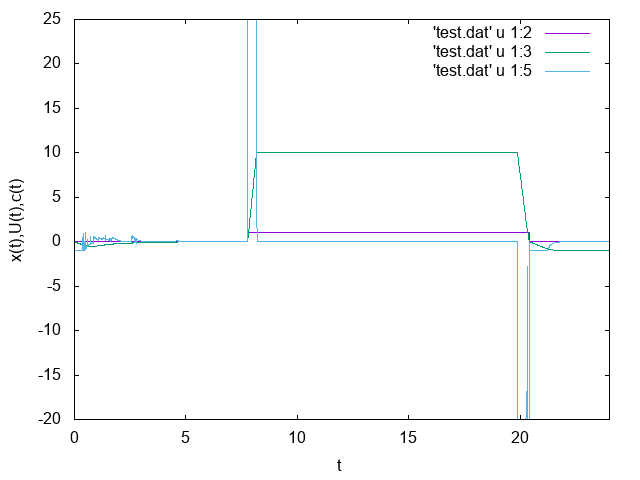

In [11]:
std::ofstream output("test.dat");
gen.outputPath(0.,0,output,false);
{
    std::stringstream ss("set xrange [0:24]\n"
                    "set xlabel \"t\"\n"
                    "set ylabel \"x(t),U(t),c(t)\"\n"
                    "p'test.dat' u 1:2 w l,'test.dat' u 1:3 w l,'test.dat' u 1:5 w l\n");
    MATH60082::figure = MATH60082::G.plotCommand(&ss);
}
MATH60082::figure

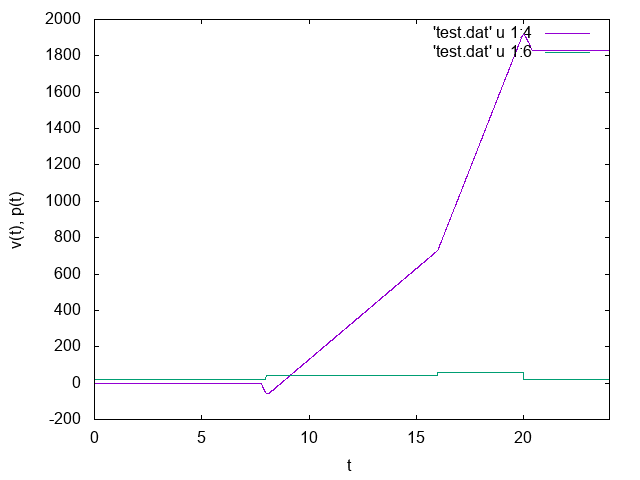

In [12]:
{
    std::stringstream ss("set xrange [0:24]\n"
                    "set xlabel \"t\"\n"
                    "set ylabel \"v(t), p(t)\"\n"
                    "p'test.dat' u 1:4 w l,'test.dat' u 1:6 w l\n");
    MATH60082::figure = MATH60082::G.plotCommand(&ss);
}
MATH60082::figure

In [13]:
gen.outputPath(0.,0);

|           t_k|           U_t|           x_t|           v_t|           c_t|           p_t|
|--------------|--------------|--------------|--------------|--------------|--------------|
|             0|             0|             0|             0|             0|            20|
|          0.01|             0|         -0.01|             0|            -1|            20|
|          0.02|             0|         -0.02|             0|            -1|            20|
|          0.03|             0|         -0.03|             0|            -1|            20|
|          0.04|             0|         -0.04|             0|            -1|            20|
|          0.05|             0|         -0.05|             0|            -1|            20|
|          0.06|             0|         -0.06|             0|            -1|            20|
|          0.07|             0|         -0.07|             0|            -1|            20|
|          0.08|             0|         -0.08|             0|            -1|    

|          0.88|             0|     -0.531258|             0|      0.347313|            20|
|          0.89|             0|     -0.528132|             0|      0.312582|            20|
|           0.9|             0|     -0.522574|             0|      0.555834|            20|
|          0.91|             0|     -0.517359|             0|      0.521481|            20|
|          0.92|             0|     -0.512467|             0|      0.489252|            20|
|          0.93|             0|     -0.507877|             0|      0.459015|            20|
|          0.94|             0|      -0.50357|             0|      0.430646|            20|
|          0.95|             0|      -0.49953|             0|       0.40403|            20|
|          0.96|             0|     -0.495739|             0|       0.37906|            20|
|          0.97|             0|     -0.492183|             0|      0.355633|            20|
|          0.98|             0|     -0.488846|             0|      0.333654|    

|          1.78|             0|     -0.236271|             0|      0.389489|            20|
|          1.79|             0|     -0.232525|             0|      0.374612|            20|
|           1.8|             0|     -0.228922|             0|      0.360303|            20|
|          1.81|             0|     -0.225457|             0|      0.346541|            20|
|          1.82|             0|     -0.222124|             0|      0.333304|            20|
|          1.83|             0|     -0.218918|             0|      0.320573|            20|
|          1.84|             0|     -0.215835|             0|      0.308328|            20|
|          1.85|             0|     -0.212869|             0|      0.296551|            20|
|          1.86|             0|     -0.210017|             0|      0.285224|            20|
|          1.87|             0|     -0.207274|             0|      0.274329|            20|
|          1.88|             0|     -0.204635|             0|      0.263851|    

|          2.68|             0|    -0.0989449|             0|      0.400177|            20|
|          2.69|             0|    -0.0951905|             0|      0.375445|            20|
|           2.7|             0|     -0.091668|             0|      0.352241|            20|
|          2.71|             0|    -0.0925012|             0|    -0.0833196|            20|
|          2.72|             0|     -0.089145|             0|      0.335621|            20|
|          2.73|             0|    -0.0902305|             0|      -0.10855|            20|
|          2.74|             0|    -0.0870146|             0|      0.321587|            20|
|          2.75|             0|    -0.0883132|             0|     -0.129854|            20|
|          2.76|             0|    -0.0852158|             0|      0.309738|            20|
|          2.77|             0|    -0.0866942|             0|     -0.147842|            20|
|          2.78|             0|    -0.0836969|             0|      0.299732|    

|          3.58|             0|     -0.038473|             0|    0.00182071|            20|
|          3.59|             0|    -0.0384559|             0|    0.00170819|            20|
|           3.6|             0|    -0.0384399|             0|    0.00160261|            20|
|          3.61|             0|    -0.0384248|             0|    0.00150357|            20|
|          3.62|             0|    -0.0384107|             0|    0.00141064|            20|
|          3.63|             0|    -0.0383975|             0|    0.00132346|            20|
|          3.64|             0|    -0.0383851|             0|    0.00124166|            20|
|          3.65|             0|    -0.0383734|             0|    0.00116493|            20|
|          3.66|             0|    -0.0383625|             0|    0.00109293|            20|
|          3.67|             0|    -0.0383523|             0|    0.00102538|            20|
|          3.68|             0|    -0.0383426|             0|   0.000962011|    

|          4.48|             0|    -0.0381975|             0|    5.8437e-06|            20|
|          4.49|             0|    -0.0381974|             0|   5.48254e-06|            20|
|           4.5|             0|    -0.0381974|             0|    5.1437e-06|            20|
|          4.51|             0|    -0.0381973|             0|   4.82581e-06|            20|
|          4.52|             0|    -0.0381973|             0|   4.52755e-06|            20|
|          4.53|             0|    -0.0381972|             0|   4.24774e-06|            20|
|          4.54|             0|    -0.0381972|             0|   3.98521e-06|            20|
|          4.55|             0|    -0.0381972|             0|   3.73891e-06|            20|
|          4.56|             0|    -0.0367382|             0|      0.145901|            20|
|          4.57|             0|    -0.0353562|             0|      0.138199|            20|
|          4.58|             0|    -0.0340471|             0|      0.130904|    

|          5.38|             0|   -0.00183341|             0|    0.00888524|            20|
|          5.39|             0|   -0.00174901|             0|    0.00844065|            20|
|           5.4|             0|   -0.00166882|             0|    0.00801831|            20|
|          5.41|             0|   -0.00159265|             0|     0.0076171|            20|
|          5.42|             0|   -0.00152029|             0|    0.00723597|            20|
|          5.43|             0|   -0.00145155|             0|     0.0068739|            20|
|          5.44|             0|   -0.00138625|             0|    0.00652995|            20|
|          5.45|             0|   -0.00132422|             0|    0.00620322|            20|
|          5.46|             0|   -0.00126529|             0|    0.00589283|            20|
|          5.47|             0|   -0.00120931|             0|    0.00559797|            20|
|          5.48|             0|   -0.00115614|             0|    0.00531787|    

|          6.28|             0|  -3.24478e-05|             0|   0.000160627|            20|
|          6.29|             0|  -3.09219e-05|             0|   0.000152596|            20|
|           6.3|             0|  -2.94722e-05|             0|   0.000144966|            20|
|          6.31|             0|   -2.8095e-05|             0|   0.000137718|            20|
|          6.32|             0|  -2.67867e-05|             0|   0.000130832|            20|
|          6.33|             0|  -2.55438e-05|             0|    0.00012429|            20|
|          6.34|             0|  -2.43631e-05|             0|   0.000118075|            20|
|          6.35|             0|  -2.32414e-05|             0|   0.000112172|            20|
|          6.36|             0|  -2.21757e-05|             0|   0.000106563|            20|
|          6.37|             0|  -2.11634e-05|             0|   0.000101235|            20|
|          6.38|             0|  -2.02016e-05|             0|    9.6173e-05|    

|          7.18|             0|  -4.61273e-07|             0|   2.29419e-06|            20|
|          7.19|             0|  -4.39478e-07|             0|   2.17948e-06|            20|
|           7.2|             0|  -4.18773e-07|             0|    2.0705e-06|            20|
|          7.21|             0|  -3.99103e-07|             0|   1.96698e-06|            20|
|          7.22|             0|  -3.80417e-07|             0|   1.86863e-06|            20|
|          7.23|             0|  -3.62665e-07|             0|    1.7752e-06|            20|
|          7.24|             0|    -3.458e-07|             0|   1.68644e-06|            20|
|          7.25|             0|  -3.29779e-07|             0|   1.60212e-06|            20|
|          7.26|             0|  -3.14559e-07|             0|   1.52201e-06|            20|
|          7.27|             0|    -3.001e-07|             0|   1.44591e-06|            20|
|          7.28|             0|  -2.86364e-07|             0|   1.37362e-06|    

|          8.08|             1|          7.76|       -58.097|            25|            40|
|          8.09|             1|          8.01|       -57.943|            25|            40|
|           8.1|             1|          8.26|       -57.689|            25|            40|
|          8.11|             1|          8.51|       -57.335|            25|            40|
|          8.12|             1|          8.76|       -56.881|            25|            40|
|          8.13|             1|          9.01|       -56.327|            25|            40|
|          8.14|             1|          9.26|       -55.673|            25|            40|
|          8.15|             1|          9.51|       -54.919|            25|            40|
|          8.16|             1|          9.76|       -54.065|            25|            40|
|          8.17|             1|          9.97|       -53.119|            21|            40|
|          8.18|             1|            10|       -52.125|             3|    

|          8.98|             1|            10|        27.875|   5.99066e-07|            40|
|          8.99|             1|            10|        28.875|   5.99066e-07|            40|
|             9|             1|            10|        29.875|   5.99066e-07|            40|
|          9.01|             1|            10|        30.875|   5.99066e-07|            40|
|          9.02|             1|            10|        31.875|   5.99066e-07|            40|
|          9.03|             1|            10|        32.875|   5.99066e-07|            40|
|          9.04|             1|            10|        33.875|   5.99066e-07|            40|
|          9.05|             1|            10|        34.875|   5.99066e-07|            40|
|          9.06|             1|            10|        35.875|   5.99066e-07|            40|
|          9.07|             1|            10|        36.875|   5.99066e-07|            40|
|          9.08|             1|            10|        37.875|   5.99066e-07|    

|          9.88|             1|            10|       117.875|   5.99066e-07|            40|
|          9.89|             1|            10|       118.875|   5.99066e-07|            40|
|           9.9|             1|            10|       119.875|   5.99066e-07|            40|
|          9.91|             1|            10|       120.875|   5.99066e-07|            40|
|          9.92|             1|            10|       121.875|   5.99066e-07|            40|
|          9.93|             1|            10|       122.875|   5.99066e-07|            40|
|          9.94|             1|            10|       123.875|   5.99066e-07|            40|
|          9.95|             1|            10|       124.875|   5.99066e-07|            40|
|          9.96|             1|            10|       125.875|   5.99066e-07|            40|
|          9.97|             1|            10|       126.875|   5.99066e-07|            40|
|          9.98|             1|            10|       127.875|   5.99066e-07|    

|         10.78|             1|            10|       207.875|   5.99066e-07|            40|
|         10.79|             1|            10|       208.875|   5.99066e-07|            40|
|          10.8|             1|            10|       209.875|   5.99066e-07|            40|
|         10.81|             1|            10|       210.875|   5.99066e-07|            40|
|         10.82|             1|            10|       211.875|   5.99066e-07|            40|
|         10.83|             1|            10|       212.875|   5.99066e-07|            40|
|         10.84|             1|            10|       213.875|   5.99066e-07|            40|
|         10.85|             1|            10|       214.875|   5.99066e-07|            40|
|         10.86|             1|            10|       215.875|   5.99066e-07|            40|
|         10.87|             1|            10|       216.875|   5.99066e-07|            40|
|         10.88|             1|            10|       217.875|   5.99066e-07|    

|         11.68|             1|            10|       297.875|   5.99066e-07|            40|
|         11.69|             1|            10|       298.875|   5.99066e-07|            40|
|          11.7|             1|            10|       299.875|   5.99066e-07|            40|
|         11.71|             1|            10|       300.875|   5.99066e-07|            40|
|         11.72|             1|            10|       301.875|   5.99066e-07|            40|
|         11.73|             1|            10|       302.875|   5.99066e-07|            40|
|         11.74|             1|            10|       303.875|   5.99066e-07|            40|
|         11.75|             1|            10|       304.875|   5.99066e-07|            40|
|         11.76|             1|            10|       305.875|   5.99066e-07|            40|
|         11.77|             1|            10|       306.875|   5.99066e-07|            40|
|         11.78|             1|            10|       307.875|   5.99066e-07|    

|         12.58|             1|            10|       387.875|   5.99066e-07|            40|
|         12.59|             1|            10|       388.875|   5.99066e-07|            40|
|          12.6|             1|            10|       389.875|   5.99066e-07|            40|
|         12.61|             1|            10|       390.875|   5.99066e-07|            40|
|         12.62|             1|            10|       391.875|   5.99066e-07|            40|
|         12.63|             1|            10|       392.875|   5.99066e-07|            40|
|         12.64|             1|            10|       393.875|   5.99066e-07|            40|
|         12.65|             1|            10|       394.875|   5.99066e-07|            40|
|         12.66|             1|            10|       395.875|   5.99066e-07|            40|
|         12.67|             1|            10|       396.875|   5.99066e-07|            40|
|         12.68|             1|            10|       397.875|   5.99066e-07|    

|         13.48|             1|            10|       477.875|   5.99066e-07|            40|
|         13.49|             1|            10|       478.875|   5.99066e-07|            40|
|          13.5|             1|            10|       479.875|   5.99066e-07|            40|
|         13.51|             1|            10|       480.875|   5.99066e-07|            40|
|         13.52|             1|            10|       481.875|   5.99066e-07|            40|
|         13.53|             1|            10|       482.875|   5.99066e-07|            40|
|         13.54|             1|            10|       483.875|   5.99066e-07|            40|
|         13.55|             1|            10|       484.875|   5.99066e-07|            40|
|         13.56|             1|            10|       485.875|   5.99066e-07|            40|
|         13.57|             1|            10|       486.875|   5.99066e-07|            40|
|         13.58|             1|            10|       487.875|   5.99066e-07|    

|         14.38|             1|            10|       567.875|   5.99066e-07|            40|
|         14.39|             1|            10|       568.875|   5.99066e-07|            40|
|          14.4|             1|            10|       569.875|   5.99066e-07|            40|
|         14.41|             1|            10|       570.875|   5.99066e-07|            40|
|         14.42|             1|            10|       571.875|   5.99066e-07|            40|
|         14.43|             1|            10|       572.875|   5.99066e-07|            40|
|         14.44|             1|            10|       573.875|   5.99066e-07|            40|
|         14.45|             1|            10|       574.875|   5.99066e-07|            40|
|         14.46|             1|            10|       575.875|   5.99066e-07|            40|
|         14.47|             1|            10|       576.875|   5.99066e-07|            40|
|         14.48|             1|            10|       577.875|   5.99066e-07|    

|         15.28|             1|            10|       657.875|   5.99066e-07|            40|
|         15.29|             1|            10|       658.875|   5.99066e-07|            40|
|          15.3|             1|            10|       659.875|   5.99066e-07|            40|
|         15.31|             1|            10|       660.875|   5.99066e-07|            40|
|         15.32|             1|            10|       661.875|   5.99066e-07|            40|
|         15.33|             1|            10|       662.875|   5.99066e-07|            40|
|         15.34|             1|            10|       663.875|   5.99066e-07|            40|
|         15.35|             1|            10|       664.875|   5.99066e-07|            40|
|         15.36|             1|            10|       665.875|   5.99066e-07|            40|
|         15.37|             1|            10|       666.875|   5.99066e-07|            40|
|         15.38|             1|            10|       667.875|   5.99066e-07|    

|         16.18|             1|            10|       783.875|   5.99066e-07|            60|
|         16.19|             1|            10|       786.875|   5.99066e-07|            60|
|          16.2|             1|            10|       789.875|   5.99066e-07|            60|
|         16.21|             1|            10|       792.875|   5.99066e-07|            60|
|         16.22|             1|            10|       795.875|   5.99066e-07|            60|
|         16.23|             1|            10|       798.875|   5.99066e-07|            60|
|         16.24|             1|            10|       801.875|   5.99066e-07|            60|
|         16.25|             1|            10|       804.875|   5.99066e-07|            60|
|         16.26|             1|            10|       807.875|   5.99066e-07|            60|
|         16.27|             1|            10|       810.875|   5.99066e-07|            60|
|         16.28|             1|            10|       813.875|   5.99066e-07|    

|         17.08|             1|            10|       1053.88|   5.99066e-07|            60|
|         17.09|             1|            10|       1056.88|   5.99066e-07|            60|
|          17.1|             1|            10|       1059.88|   5.99066e-07|            60|
|         17.11|             1|            10|       1062.88|   5.99066e-07|            60|
|         17.12|             1|            10|       1065.88|   5.99066e-07|            60|
|         17.13|             1|            10|       1068.88|   5.99066e-07|            60|
|         17.14|             1|            10|       1071.88|   5.99066e-07|            60|
|         17.15|             1|            10|       1074.88|   5.99066e-07|            60|
|         17.16|             1|            10|       1077.88|   5.99066e-07|            60|
|         17.17|             1|            10|       1080.88|   5.99066e-07|            60|
|         17.18|             1|            10|       1083.88|   5.99066e-07|    

|         17.98|             1|            10|       1323.88|   5.99066e-07|            60|
|         17.99|             1|            10|       1326.88|   5.99066e-07|            60|
|            18|             1|            10|       1329.88|   5.99066e-07|            60|
|         18.01|             1|            10|       1332.88|   5.99066e-07|            60|
|         18.02|             1|            10|       1335.88|   5.99066e-07|            60|
|         18.03|             1|            10|       1338.88|   5.99066e-07|            60|
|         18.04|             1|            10|       1341.88|   5.99066e-07|            60|
|         18.05|             1|            10|       1344.88|   5.99066e-07|            60|
|         18.06|             1|            10|       1347.88|   5.99066e-07|            60|
|         18.07|             1|            10|       1350.88|   5.99066e-07|            60|
|         18.08|             1|            10|       1353.88|   5.99066e-07|    

|         18.88|             1|            10|       1593.88|   5.99066e-07|            60|
|         18.89|             1|            10|       1596.88|   5.99066e-07|            60|
|          18.9|             1|            10|       1599.88|   5.99066e-07|            60|
|         18.91|             1|            10|       1602.88|   5.99066e-07|            60|
|         18.92|             1|            10|       1605.88|   5.99066e-07|            60|
|         18.93|             1|            10|       1608.88|   5.99066e-07|            60|
|         18.94|             1|            10|       1611.88|   5.99066e-07|            60|
|         18.95|             1|            10|       1614.88|   5.99066e-07|            60|
|         18.96|             1|            10|       1617.88|   5.99066e-07|            60|
|         18.97|             1|            10|       1620.88|   5.99066e-07|            60|
|         18.98|             1|            10|       1623.88|   5.99066e-07|    

|         19.78|             1|            10|       1863.88|   5.99066e-07|            60|
|         19.79|             1|            10|       1866.88|   5.99066e-07|            60|
|          19.8|             1|            10|       1869.88|   5.99066e-07|            60|
|         19.81|             1|            10|       1872.88|   5.99066e-07|            60|
|         19.82|             1|            10|       1875.88|   5.99066e-07|            60|
|         19.83|             1|            10|       1878.88|   5.99066e-07|            60|
|         19.84|             1|            10|       1881.88|   5.99066e-07|            60|
|         19.85|             1|            10|       1884.88|   5.99066e-07|            60|
|         19.86|             1|            10|       1887.88|   5.99066e-07|            60|
|         19.87|             1|            10|       1890.88|   5.99066e-07|            60|
|         19.88|             1|           9.8|       1893.82|           -20|    

|         20.68|             0|         -0.28|       1827.69|            -1|            20|
|         20.69|             0|         -0.29|       1827.69|            -1|            20|
|          20.7|             0|          -0.3|       1827.69|            -1|            20|
|         20.71|             0|         -0.31|       1827.69|            -1|            20|
|         20.72|             0|         -0.32|       1827.69|            -1|            20|
|         20.73|             0|         -0.33|       1827.69|            -1|            20|
|         20.74|             0|         -0.34|       1827.69|            -1|            20|
|         20.75|             0|         -0.35|       1827.69|            -1|            20|
|         20.76|             0|         -0.36|       1827.69|            -1|            20|
|         20.77|             0|         -0.37|       1827.69|            -1|            20|
|         20.78|             0|         -0.38|       1827.69|            -1|    

|         21.58|             0|     -0.947476|       1827.69|    -0.0943784|            20|
|         21.59|             0|     -0.948362|       1827.69|    -0.0885455|            20|
|          21.6|             0|     -0.949193|       1827.69|    -0.0830731|            20|
|         21.61|             0|     -0.949972|       1827.69|    -0.0779389|            20|
|         21.62|             0|     -0.950703|       1827.69|     -0.073122|            20|
|         21.63|             0|     -0.951389|       1827.69|    -0.0686028|            20|
|         21.64|             0|     -0.952033|       1827.69|    -0.0643629|            20|
|         21.65|             0|     -0.952637|       1827.69|    -0.0603851|            20|
|         21.66|             0|     -0.953203|       1827.69|    -0.0566531|            20|
|         21.67|             0|     -0.953735|       1827.69|    -0.0531517|            20|
|         21.68|             0|     -0.954233|       1827.69|    -0.0498668|    

|         22.48|             0|     -0.961757|       1827.69|  -0.000302914|            20|
|         22.49|             0|      -0.96176|       1827.69|  -0.000284193|            20|
|          22.5|             0|     -0.961763|       1827.69|  -0.000266629|            20|
|         22.51|             0|     -0.961765|       1827.69|   -0.00025015|            20|
|         22.52|             0|     -0.961768|       1827.69|   -0.00023469|            20|
|         22.53|             0|      -0.96177|       1827.69|  -0.000220186|            20|
|         22.54|             0|     -0.961772|       1827.69|  -0.000206577|            20|
|         22.55|             0|     -0.961774|       1827.69|   -0.00019381|            20|
|         22.56|             0|     -0.961776|       1827.69|  -0.000181832|            20|
|         22.57|             0|     -0.961778|       1827.69|  -0.000170594|            20|
|         22.58|             0|     -0.961779|       1827.69|  -0.000160051|    

|         23.38|             0|     -0.961803|       1827.69|  -9.72224e-07|            20|
|         23.39|             0|     -0.961803|       1827.69|  -9.12138e-07|            20|
|          23.4|             0|     -0.961803|       1827.69|  -8.55764e-07|            20|
|         23.41|             0|     -0.961803|       1827.69|  -8.02875e-07|            20|
|         23.42|             0|     -0.961803|       1827.69|  -7.53255e-07|            20|
|         23.43|             0|     -0.961803|       1827.69|  -7.06701e-07|            20|
|         23.44|             0|     -0.961803|       1827.69|  -6.63025e-07|            20|
|         23.45|             0|     -0.961803|       1827.69|  -6.22047e-07|            20|
|         23.46|             0|     -0.961803|       1827.69|  -5.83603e-07|            20|
|         23.47|             0|     -0.961803|       1827.69|  -5.47534e-07|            20|
|         23.48|             0|     -0.961803|       1827.69|  -5.13695e-07|    

In [14]:
MSC_PROJECTS::Generator dflt_gen;
dflt_gen.defaultSetup(10,240,24,1.e-8);

In [15]:
dflt_gen.electricityPrice = [](double t){
            if(t<8.)return 20.;
            if(t<16.)return 40.;
            if(t<20.)return 60.;
            return 20.;
};

In [16]:
dflt_gen.solve();

|             k|           U_t|           x_t|           v_t|           c_t|
|--------------|--------------|--------------|--------------|--------------|
|             0|             0|            -1|         154.2|      0.236068|
|             0|             0|             0|         154.2|     -0.236068|
|             0|             1|             0|         141.6|             1|
|             0|             1|             1|         145.8|             1|
|             0|             2|             1|         146.6|            -1|
|             0|             2|             2|         129.2|            -1|
|             0|             3|             0|         153.7|            -1|
|             0|             3|             1|         149.2|            -1|


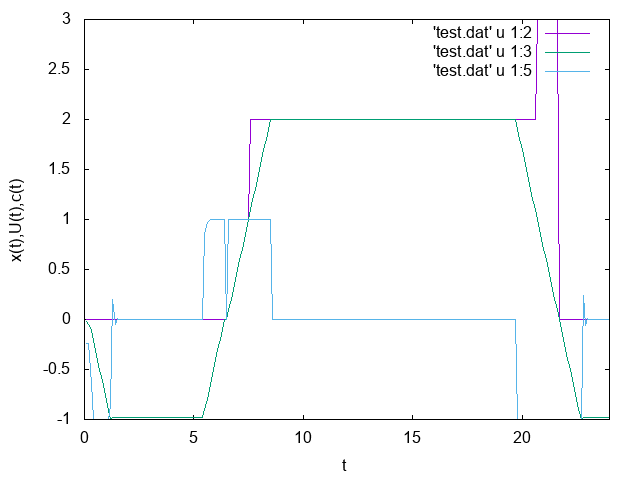

In [17]:
std::ofstream output("test.dat");
dflt_gen.outputPath(0.,0,output,false);
{
    std::stringstream ss("set xrange [0:24]\n"
                    "set xlabel \"t\"\n"
                    "set ylabel \"x(t),U(t),c(t)\"\n"
                    "p'test.dat' u 1:2 w l,'test.dat' u 1:3 w l,'test.dat' u 1:5 w l\n");
    MATH60082::figure = MATH60082::G.plotCommand(&ss);
}
MATH60082::figure

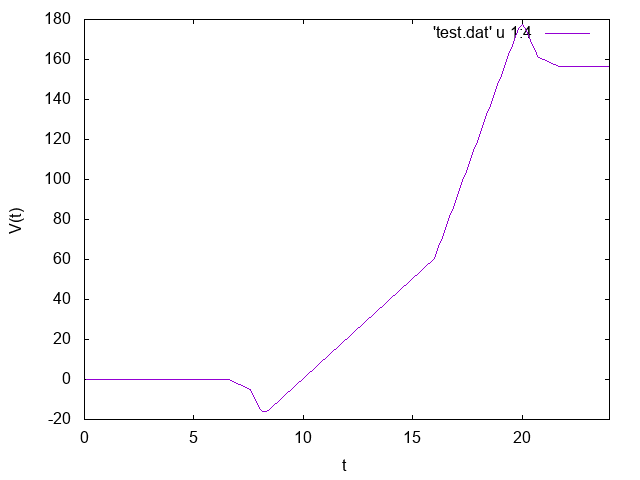

In [18]:
{
    std::stringstream ss("set xrange [0:24]\n"
                    "set xlabel \"t\"\n"
                    "set ylabel \"V(t)\"\n"
                    "p'test.dat' u 1:4 w l\n");
    MATH60082::figure = MATH60082::G.plotCommand(&ss);
}
MATH60082::figure

In [19]:
MSC_PROJECTS::Generator K;

In [20]:
K.karolisExampleSetup(20,120,1.e-6);

 SETUP STATE 0 WITH n=5
 SETUP STATE 1 WITH n=240
 SETUP STATE 2 WITH n=17
 SETUP STATE 3 WITH n=7
 SETUP STATE 4 WITH n=17
 SETUP STATE 5 WITH n=240


In [21]:
K.solve();

|             k|           U_t|           x_t|           v_t|           c_t|
|--------------|--------------|--------------|--------------|--------------|
|             0|             0|           -13|        345050|      0.236068|
|             0|             0|           -12|        345050|            -1|
|             0|             1|           -12|        330593|             1|
|             0|             1|             0|        389015|             1|
|             0|             2|             0|        389282|            60|
|             0|             2|            50|        403001|             0|
|             0|             3|            50|        403136|             6|
|             0|             3|            90|        408129|  -6.44989e-05|
|             0|             4|             0|        356222|            -0|
|             0|             4|            50|        345574|            -6|
|             0|             5|           -12|        344960|            -1|

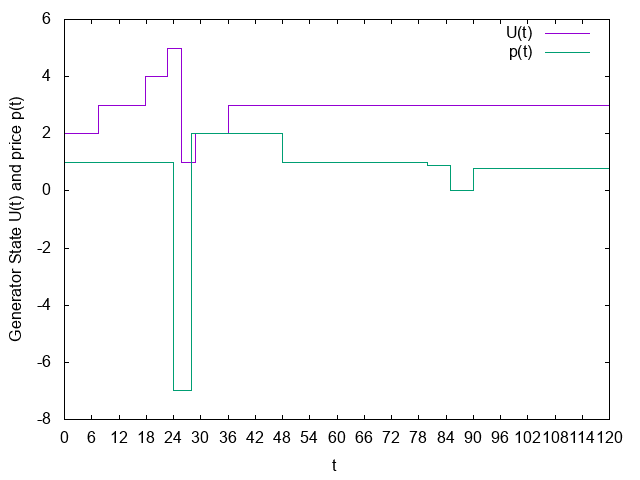

In [22]:
{
    std::ofstream output("karolis.dat");
    K.outputPath(0.,1,output,false);
    std::stringstream ss("set xrange [0:120]\n"
                    "set xlabel \"t\"\n"
                    "set xtics 6\n"
                    "set ylabel \"Generator State U(t) and price p(t)\"\n"
                    "p'karolis.dat' u 1:2 ti \"U(t)\" w l,'karolis.dat' u 1:($6/100) ti \"p(t)\" w l\n");
    MATH60082::figure = MATH60082::G.plotCommand(&ss);
}
MATH60082::figure

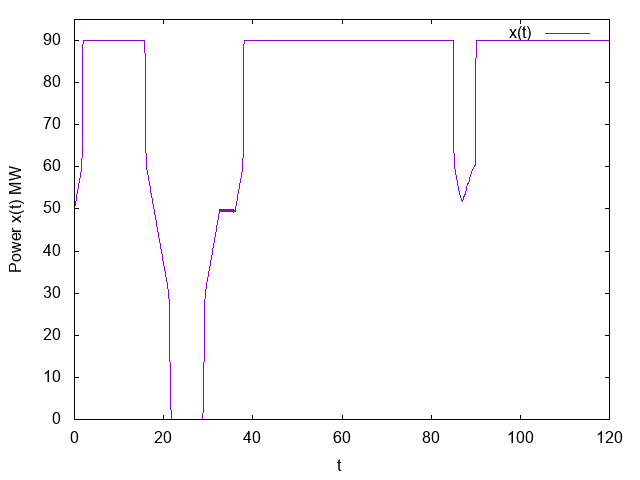

In [23]:
{
    std::ofstream output("karolis.dat");
    K.outputPath(50.,3,output,false);
    std::stringstream ss("set xrange [0:120]\n"
                         "set yrange [0:95]\n"
                    "set xlabel \"t\"\n"
                    "set ylabel \"Power x(t) MW\"\n"
                    "p'karolis.dat' u 1:($3) ti \"x(t)\" w l\n");
    MATH60082::figure = MATH60082::G.plotCommand(&ss);
}
MATH60082::figure

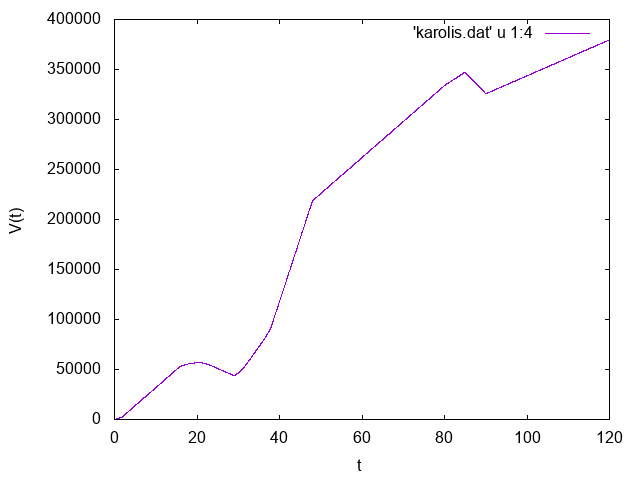

In [24]:
{
    std::stringstream ss("set xrange [0:120]\n"
                    "set xlabel \"t\"\n"
                    "set ylabel \"V(t)\"\n"
                    "p'karolis.dat' u 1:4 w l\n");
    MATH60082::figure = MATH60082::G.plotCommand(&ss);
}
MATH60082::figure